Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import os
import zipfile
import random
import shutil
import cv2
import tensorflow as tf

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [10]:
#Install kaggle API client
!pip install -q kaggle

In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
mv kaggle.json /root/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d aditisatsangi/dataset-indian-vehicles
!unzip \*.zip && rm *.zip



100% 910M/913M [00:11<00:00, 149MB/s]
100% 913M/913M [00:11<00:00, 80.0MB/s]
Archive:  dataset-indian-vehicles.zip
  inflating: Vehicles./Vehicles/Auto/Thumbs.db  
  inflating: Vehicles./Vehicles/Auto/img 0100.PNG  
  inflating: Vehicles./Vehicles/Auto/img 0127.jpg  
  inflating: Vehicles./Vehicles/Auto/img 095.PNG  
  inflating: Vehicles./Vehicles/Auto/img 096.PNG  
  inflating: Vehicles./Vehicles/Auto/img 097.PNG  
  inflating: Vehicles./Vehicles/Auto/img 098.PNG  
  inflating: Vehicles./Vehicles/Auto/img 099.PNG  
  inflating: Vehicles./Vehicles/Auto/img 101.PNG  
  inflating: Vehicles./Vehicles/Auto/img 102.PNG  
  inflating: Vehicles./Vehicles/Auto/img 103.PNG  
  inflating: Vehicles./Vehicles/Auto/img 104.PNG  
  inflating: Vehicles./Vehicles/Auto/img 105.PNG  
  inflating: Vehicles./Vehicles/Auto/img 106.PNG  
  inflating: Vehicles./Vehicles/Auto/img 107.PNG  
  inflating: Vehicles./Vehicles/Auto/img 108.jpg  
  inflating: Vehicles./Vehicles/Auto/img 109.PNG  
  inflating: Vehic

In [15]:
dataset_path = '/content/IVDB'

In [16]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

Training and Validation Dataset

In [17]:
class_names = ['Auto', 'Bus','Car','Truck']
# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   validation_split=0.2  # Split the dataset into training and validation
)

data = datagen.flow_from_directory(
   '/content/Vehicles./Vehicles',
   target_size=(224, 224),
   batch_size=BATCH_SIZE,
   #validation_split=0.2,
   subset='training',  # Specify 'training' to get the training subset
   seed=42,
   class_mode='categorical'  # Return class names as labels
)

class_names = data.class_indices

Found 2130 images belonging to 4 classes.


In [ ]:
class_indices = data.class_indices
print(class_indices)

{'Auto': 0, 'Bus': 1, 'Car': 2, 'Truck': 3}


In [ ]:
import tensorflow as tf
# Load and split the dataset using data augmentation
train_generator  = datagen.flow_from_directory(
    '/content/Vehicles/Vehicles',
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42,
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    '/content/Vehicles/Vehicles',
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42,
    subset='validation'
)

Found 738 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


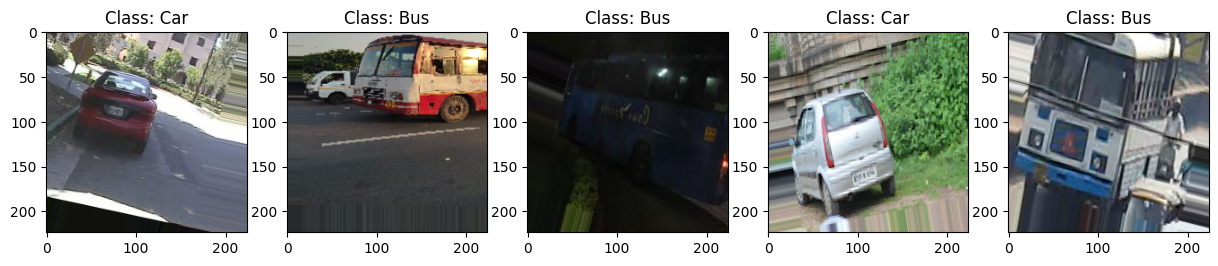

In [ ]:
import matplotlib.pyplot as plt

# Load the first batch of data (batch size = 32)
batch = next(data)

# Get the first 5 images and their one-hot encoded labels
images, one_hot_labels = batch[0][:5], batch[1][:5]

# Set the figure size for larger images
plt.figure(figsize=(15, 5))

# Iterate through the images and labels
for i in range(5):
    # Find the class index (1 in one-hot encoding)
    class_index = list(one_hot_labels[i]).index(1)

    # Get the class name from the class index
    class_name = list(data.class_indices.keys())[list(data.class_indices.values()).index(class_index)]

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Class: {class_name}')

plt.show()

In [ ]:
for i in range(1):  # Preview the first batch
    batch = next(data)
    images, labels = batch
    # Process or display the images and labels as needed
    print(labels)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 32

In [ ]:
# Load the InceptionV3 model with pre-trained weights
base_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top (classification) layers
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model's layers (optional)
base_model.trainable = False

num_classes = len(class_names)  # Number of classes
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class

# Update the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    output_layer  # Updated output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 516       
                                                                 
Total params: 22065572 (84.17 MB)
Trainable params: 262788 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________

Training Model

In [ ]:
batch_size=32
# Define the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
23/23 [==============================] - 213s 6s/step - loss: 0.8259 - accuracy: 0.7266 - val_loss: 0.5923 - val_accuracy: 0.7625
Epoch 2/10
23/23 [==============================] - 123s 5s/step - loss: 0.4110 - accuracy: 0.8541 - val_loss: 0.4935 - val_accuracy: 0.8375
Epoch 3/10
23/23 [==============================] - 139s 6s/step - loss: 0.3879 - accuracy: 0.8527 - val_loss: 0.3656 - val_accuracy: 0.8438
Epoch 4/10
23/23 [==============================] - 142s 6s/step - loss: 0.2936 - accuracy: 0.8966 - val_loss: 0.4515 - val_accuracy: 0.8188
Epoch 5/10
23/23 [==============================] - 146s 6s/step - loss: 0.2788 - accuracy: 0.9065 - val_loss: 0.4978 - val_accuracy: 0.8062
Epoch 6/10
23/23 [==============================] - 140s 6s/step - loss: 0.2506 - accuracy: 0.9079 - val_loss: 0.4068 - val_accuracy: 0.8687
Epoch 7/10
23/23 [==============================] - 139s 6s/step - loss: 0.3010 - accuracy: 0.8966 - val_loss: 0.3829 - val_accuracy: 0.8813
Epoch 8/10
23

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 516       
                                                                 
Total params: 22065572 (84.17 MB)
Trainable params: 262788 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________

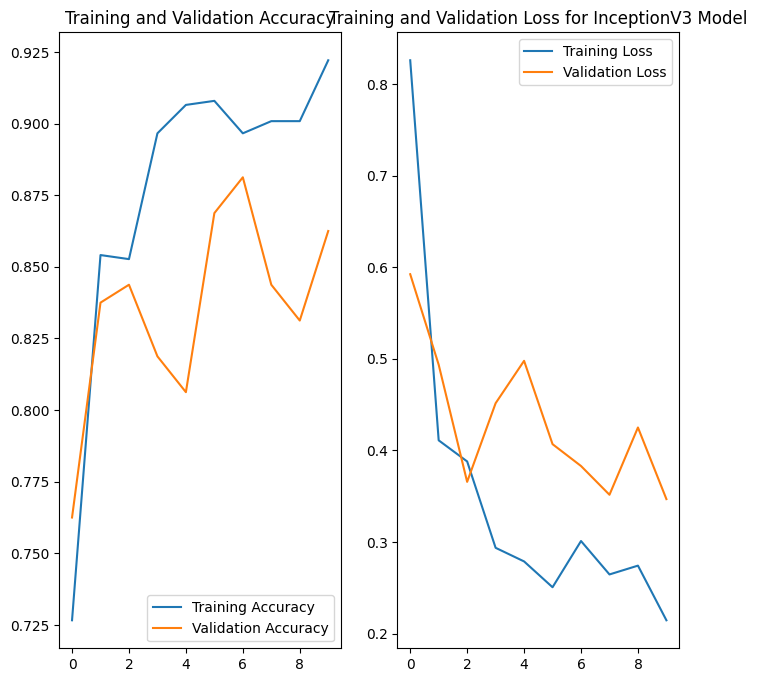

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=10
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for InceptionV3 Model')
plt.show()

Prediction & Accuracy

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f'Validation Loss: {validation_loss:.4f}')
print(f'Validation Accuracy: {validation_accuracy*100:.2f}%')

6/6 [==============================] - 30s 5s/step - loss: 0.3824 - accuracy: 0.8852
Validation Loss: 0.3824
Validation Accuracy: 88.52%


In [ ]:
# Save the trained model
model.save('vehicle_classification_model_InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
class_names = ['Auto', 'Bus','Car','Truck']

1/1 [==============================] - 2s 2s/step
Predicted Class: (3, 'Truck')


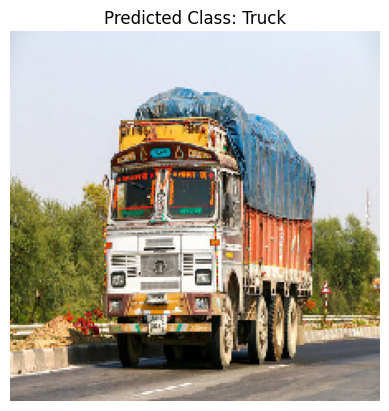

In [ ]:
img_path = '/content/truck1.jpg'
image_height = 224
image_width = 224
img = image.load_img(img_path, target_size=(image_height, image_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest predicted probability
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 145ms/step
Predicted Class: (2, 'Car')


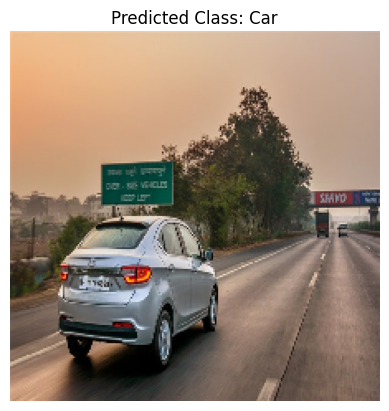

In [ ]:
img_path = '/content/car1.jpg'
image_height = 224
image_width = 224
img = image.load_img(img_path, target_size=(image_height, image_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest predicted probability
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

# New section

1/1 [==============================] - 0s 146ms/step
Predicted Class: (0, 'Auto')


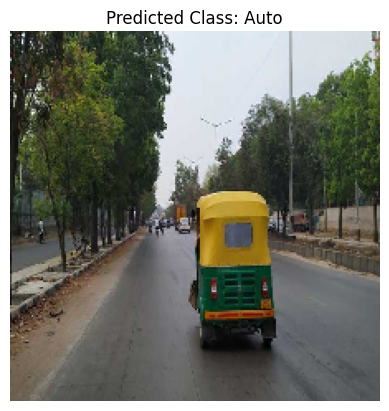

In [ ]:
img_path = '/content/auto1.jpg'
image_height = 224
image_width = 224
img = image.load_img(img_path, target_size=(image_height, image_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest predicted probability
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 157ms/step
Predicted Class: (1, 'Bus')


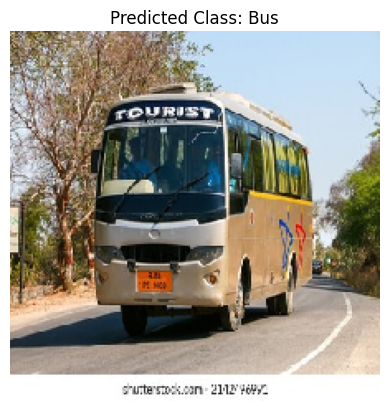

In [ ]:
img_path = '/content/bus1.jpg'
image_height = 224
image_width = 224
img = image.load_img(img_path, target_size=(image_height, image_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest predicted probability
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()